<a href="https://www.kaggle.com/code/rashidrk/digit-recognizer-with-vit-99-4-acc?scriptVersionId=209615182" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

Transformers are very powerful architectures and they have recolutionalized NLP. But did you know that they can also be used on Image ?. So in this notebook am going to share how we can train our very own Vision Transformer (ViT) to be able to classify digits. all the ideas are beginner friendly and we will be using huggingface 🤗 transformers library.

# What are Vision Transformers ?

Vision Transformers were introduced by a team of researchers at google brains in [a 2021 paper](https://arxiv.org/abs/2010.11929). and basically they work in just 3 major steps;

* split an image in sub-image patches
* Embed each patch with a linear projection
* Each embedded patch becomes a token, and the resulting sequence of embedded patches is the sequence you pass to the model.

![](https://huggingface.co/blog/assets/51_fine_tune_vit/vit-figure.jpg)
<center> <i> Image from https://huggingface.co/blog/fine-tune-vit </i> </center>

Lets get to it

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

!pip install datasets -qq

In [2]:
from datasets import Dataset

In [3]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocessing

So Vision transformers are able to work on only data that has 3 channels i.e. Colored data (RGB) but our dataset is in gray scale. So to overcome this issue, we are going to colorize our digits and as a result we will end up with Images with 3 channels.

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import datasets
import torch
from numpy import random

In [5]:
#define the coloring function
def color(a):
    img = np.concatenate([a.reshape((28, 28, 1)) * random.uniform(0.3, 1.0),
                          a.reshape((28, 28, 1)) * random.uniform(0.3, 1.0),
                          a.reshape((28, 28, 1)) * random.uniform(0.3, 1.0)], axis=2)

    return img.astype(np.uint8)

In [6]:
def convert_to_image(pixels: np.ndarray):
    image = Image.fromarray(pixels)

    return image

In [7]:
raw_dataset = Dataset.from_pandas(train_df)
features = list(raw_dataset.features.keys())[1:]

In [8]:
def mapper(batch):
    label = batch['label']
    img_pixels = []
    for feature in features:
        img_pixels.append(batch[feature])
        
    img_pixels = np.array(img_pixels)
    img_pixels_rgb = color(img_pixels)    
    image = convert_to_image(img_pixels_rgb)
    return {"image": image, "label": label}

In [9]:
#map the raw dataset to a new colored dataset
dataset = raw_dataset.map(mapper, num_proc=4, batch_size=32)

#0:   0%|          | 0/10500 [00:00<?, ?ex/s]

#1:   0%|          | 0/10500 [00:00<?, ?ex/s]

#2:   0%|          | 0/10500 [00:00<?, ?ex/s]

#3:   0%|          | 0/10500 [00:00<?, ?ex/s]

In [10]:
#remove the unnecessary features
dataset = dataset.remove_columns(features)

In [11]:
dataset = dataset.train_test_split(seed=42)

In [12]:
dataset['train']['image'][2]

# Visualize our new colored Images

[0 1 2 3 4 5 6 7 8 9]


  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

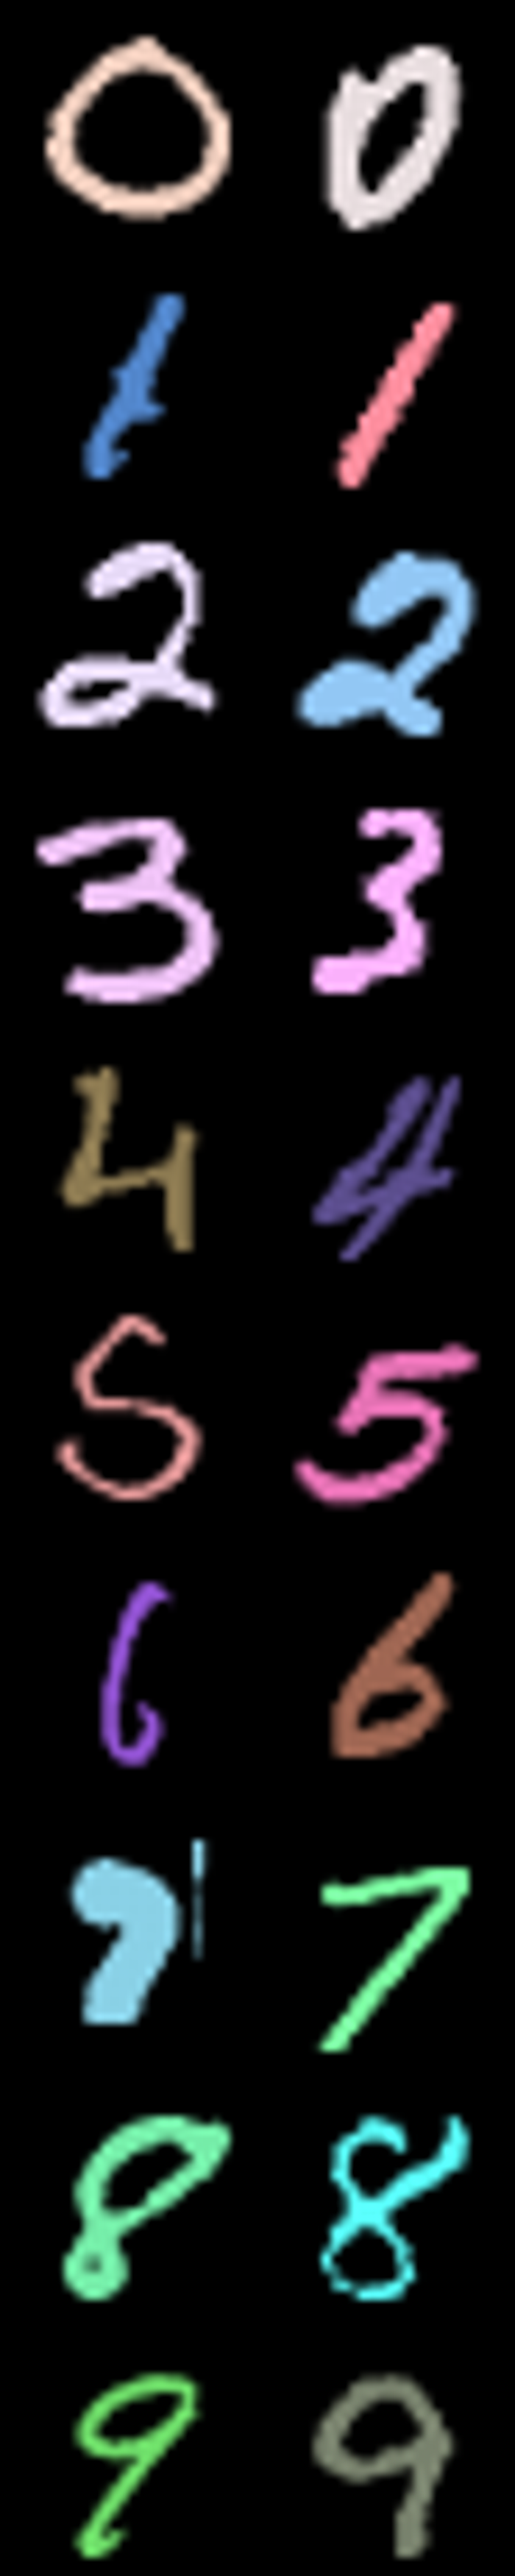

In [13]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 42, examples_per_class: int = 2, size=(350, 350)):

    w, h = size
    labels = np.unique(ds['train']['label'])
    print(labels)
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):
        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            

    return grid

show_examples(dataset)


# Model training

To train similar to NLP cases where we need a tokenizer to tokenize our sentences, for Images we need a processor and it will be responsible for Normalizing the input Images and also reshaping them to dimensions of 224.

ViTImageProcessor { <br>
  "do_normalize": true,<br>
  "do_resize": true,<br>
  "image_mean": [<br>
    0.5,<br>
    0.5,<br>
    0.5<br>
  ],<br>
  "image_std": [<br>
    0.5,<br>
    0.5,<br>
    0.5<br>
  ],
  "resample": 2,<br>
  "size": 224<br>
}


In [14]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor(do_rescale=False).from_pretrained(model_name_or_path)


2024-11-25 22:11:12.777364: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 22:11:12.777508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 22:11:12.914551: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [15]:
sample = dataset['train']['image'][0]

In [16]:
processor(sample)

{'pixel_values': [array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32)]}

**Normalized Image**

In [17]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs

In [18]:
prepared_dataset = dataset.with_transform(transform)

In [19]:
#define the collate function
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }


In [20]:
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


In [21]:
#load the model
from transformers import ViTForImageClassification

labels = np.unique(dataset['train']['label'])

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels)
)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-digit-recognizer",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=2,
  fp16=True,
  save_steps=500,
  eval_steps=500,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


In [23]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_dataset["train"],
    eval_dataset=prepared_dataset["test"],
    tokenizer=processor,
)


In [24]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,0.106400,0.108720,0.972571
1000,0.011300,0.057730,0.986762
1500,0.108300,0.085851,0.978857
2000,0.082000,0.029093,0.992286
2500,0.006000,0.029042,0.992286
3000,0.002400,0.027886,0.993143
3500,0.001400,0.023441,0.994190


We get around a 99.5 acc with just 2 epochs 🔥, Imagine what we get with 4 or 5 epochs 🤔. and since the trainer returns the best model at the end, no need to worry about overfitting. anyways i will leave this for the reader to test out and see. feel free to leave a comment about your findings 😊

In [25]:
#save the best model
trainer.save_model("best_model/")

# Testing the Model

Similar as before, we are going to get the raw test set, convert it to RGB images and there after we are going to create a transformer pipeline for Inference predictions.

In [26]:
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
raw_test_dataset = Dataset.from_pandas(test_df)

In [28]:
def test_mapper(batch):
    img_pixels = []
    for feature in features:
        img_pixels.append(batch[feature])
        
    img_pixels = np.array(img_pixels)
    img_pixels_rgb = color(img_pixels)    
    image = convert_to_image(img_pixels_rgb)
    return {"image": image}

In [29]:
test_dataset = raw_test_dataset.map(test_mapper, num_proc=4, batch_size=32)
test_dataset = test_dataset.remove_columns(features)
test_dataset

#0:   0%|          | 0/7000 [00:00<?, ?ex/s]

#1:   0%|          | 0/7000 [00:00<?, ?ex/s]

#2:   0%|          | 0/7000 [00:00<?, ?ex/s]

#3:   0%|          | 0/7000 [00:00<?, ?ex/s]

Dataset({
    features: ['image'],
    num_rows: 28000
})

In [30]:
sample = test_dataset['image'][:3]
sample

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=28x28>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=28x28>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=28x28>]

In [31]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-classification", model="/kaggle/working/best_model", device=0)

In [32]:
pipe(sample)

[[{'label': 'LABEL_2', 'score': 0.9989872574806213},
  {'label': 'LABEL_9', 'score': 0.00023132776550482959},
  {'label': 'LABEL_3', 'score': 0.00020330824190750718},
  {'label': 'LABEL_0', 'score': 0.00010707606270443648},
  {'label': 'LABEL_5', 'score': 0.0001016392488963902}],
 [{'label': 'LABEL_0', 'score': 0.9992517828941345},
  {'label': 'LABEL_5', 'score': 0.00014586148608941585},
  {'label': 'LABEL_2', 'score': 0.00011949626787099987},
  {'label': 'LABEL_9', 'score': 9.148920798907056e-05},
  {'label': 'LABEL_8', 'score': 8.703641651663929e-05}],
 [{'label': 'LABEL_9', 'score': 0.9979839324951172},
  {'label': 'LABEL_4', 'score': 0.0005581656587310135},
  {'label': 'LABEL_8', 'score': 0.0004025289963465184},
  {'label': 'LABEL_3', 'score': 0.0002735736779868603},
  {'label': 'LABEL_5', 'score': 0.00022006890503689647}]]

In [33]:
 def extract_label(prediction):
    label = prediction[0]['label']
    index = label.find('_')
    label_num = int(label[index + 1])
    return label_num

In [34]:
from tqdm import tqdm

In [35]:
len(test_dataset['image'])

28000

In [36]:
def create_submission_df(test_dataset, batch_size=50) -> pd.DataFrame:
    df = pd.DataFrame()
    predicted_labels = []

    # Process the dataset in batches
    for i in tqdm(range(0, len(test_dataset), batch_size)):
        batch_data = test_dataset[i:i + batch_size]
        img_ids = np.arange(i + 1, i + batch_size + 1) 

        predictions = pipe(batch_data)

        for pred, label, img_id in zip(predictions, [extract_label(p) for p in predictions], img_ids):
            predicted_labels.append({'ImageId': img_id, 'Label': label})

    df = pd.DataFrame(predicted_labels)
    return df


In [37]:
submission = create_submission_df(test_dataset['image'])
submission.shape

  2%|▏         | 9/560 [00:07<07:54,  1.16it/s]/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 560/560 [08:06<00:00,  1.15it/s]


(28000, 2)

In [38]:
submission.head(n = 7)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0


In [39]:
submission.to_csv("submission.csv", index = False)

# Conclusion

Vision Transformers are very powerful and can definetely generate even results better than this with the right parameters.

Anyways **thanks for viewing and kindly give an upvote if you found this helpful :)**